In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.models import model_from_json

In [3]:
import plotting
from sklearn.metrics import accuracy_score

In [4]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [5]:
f5 = h5py.File(data_loc+file_str, 'r')

In [6]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [7]:
model_name = 'rnn_GRU.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid'

In [8]:
keras_loc = '/sdf/home/r/rafaeltl/home/rafaeltl/ML/L1BTag/Mar28/hls-rnn-btag/rnn/keras/'

In [9]:
arch_json = open(f'{keras_loc}/model_'+model_name+'_arch.json', 'r').read()
model = model_from_json(arch_json)
model.load_weights(f'{keras_loc}/model_{model_name}_weights.h5')

In [10]:
y_keras = model.predict(x_test, batch_size=2**10)

In [11]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

Accuracy: 0.7282554465325128


In [12]:
import hls4ml

/src/hls4ml/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [13]:
reuse_factor = 100
# default_prec = '32,10,AP_RND_ZERO,AP_SAT_SYM'
default_prec = '22,10'
lut_size = 2**(13)
lut_prec = '18,1'

In [14]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name',
                                              default_precision=f'ap_fixed<{default_prec}>',
                                              default_reuse_factor=reuse_factor)

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: gru, layer type: GRU
  -> Activation (tanh), layer name: gru
Layer name: dense_0, layer type: Dense
  -> Activation (relu), layer name: dense_0
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: output_softmax, layer type: Dense
  -> Activation (softmax), layer name: output_softmax


In [15]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

config['Model']['Strategy'] = 'Resource'

In [16]:
for layer in config['LayerName'].keys():
    if 'gru' in layer or 'lstm' in layer:
        config['LayerName'][layer]['table_t'] = f'ap_fixed<{lut_prec}>'
        config['LayerName'][layer]['table_size'] = str(lut_size)

In [17]:
print(config)

{'Model': {'Precision': 'ap_fixed<22,10>', 'ReuseFactor': 100, 'Strategy': 'Resource'}, 'LayerName': {'input_1': {'Precision': {'result': 'ap_fixed<22,10>'}, 'Trace': True}, 'gru': {'Precision': 'ap_fixed<22,10>', 'Trace': True, 'table_t': 'ap_fixed<18,1>', 'table_size': '8192'}, 'gru_tanh': {'Precision': 'ap_fixed<22,10>', 'ReuseFactor': 100, 'table_size': '8192', 'table_t': 'ap_fixed<18,1>', 'Trace': True}, 'dense_0': {'Precision': {'weight': 'ap_fixed<22,10>', 'bias': 'ap_fixed<22,10>', 'result': 'ap_fixed<22,10>'}, 'ReuseFactor': 100, 'Trace': True}, 'dense_0_relu': {'Precision': 'ap_fixed<22,10>', 'ReuseFactor': 100, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Trace': True}, 'dense_1': {'Precision': {'weight': 'ap_fixed<22,10>', 'bias': 'ap_fixed<22,10>', 'result': 'ap_fixed<22,10>'}, 'ReuseFactor': 100, 'Trace': True}, 'dense_1_relu': {'Precision': 'ap_fixed<22,10>', 'ReuseFactor': 100, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Trace': True}, 'output_softmax': {'Pre

In [18]:
project_name = f'model_{model_name}_{reuse_factor}_{default_prec}_{lut_prec}_{lut_size}'
print(project_name)

model_rnn_GRU.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid_100_22,10_18,1_8192


In [19]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=f'{project_name}/hls4ml_prj')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 15, 6]], output shape: [None, 15, 6]
Layer name: gru, layer type: GRU, input shapes: [[None, 15, 6]], output shape: [None, 120]
Layer name: dense_0, layer type: Dense, input shapes: [[None, 120]], output shape: [None, 50]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 50]], output shape: [None, 10]
Layer name: output_softmax, layer type: Dense, input shapes: [[None, 10]], output shape: [None, 3]
Creating HLS model


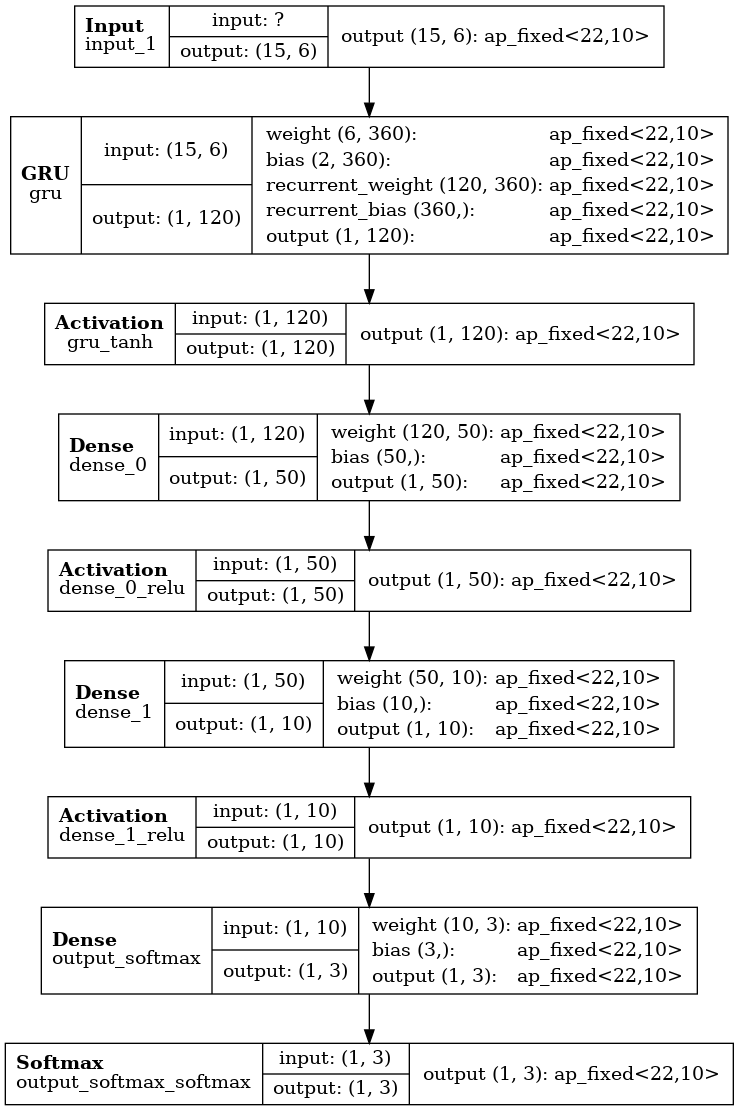

In [20]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [21]:
hls_model.compile()

Writing HLS project
Done


In [22]:
x_test_cont = np.ascontiguousarray(x_test[:10000,:,:])

In [23]:
y_hls = hls_model.predict(x_test_cont)

In [24]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test[:10000], axis=1), np.argmax(y_hls, axis=1))))

Keras  Accuracy: 0.7282554465325128
hls4ml Accuracy: 0.6981


In [25]:
print(
accuracy_score(np.argmax(y_test[:10000], axis=1), np.argmax(y_hls, axis=1))/    accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))  )

0.9585922128339806


In [ ]:
import myprofiling

In [ ]:
myprofiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])

In [ ]:
import os
os.environ['PATH'] = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LM_LICENSE_FILE'] = '2100@rdlic1:2100@rdlic2:2100@rdlic3'

In [ ]:
os.system("hls4ml build -p model_rnn_GRU.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid_modPrec16.6/hls4ml_prj")

In [ ]:
?hls_model.build

In [ ]:
from contextlib import redirect_stdout

In [ ]:
with open('out.txt', 'w') as f:
    with redirect_stdout(f):
        hls4ml.report.read_vivado_report(f'{project_name}/hls4ml_prj')

In [ ]:
print(rep)